In [3]:
import sys
ROOT_DIR = '..'
sys.path.append(ROOT_DIR)

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# load data
# filename = '../data/25-09-19_data_labeled_by_annotations.p' # with background
filename = '../data/30-09-19_data_labeled_by_annotations.p'   # without background

f = open(filename, 'rb')
data = pickle.load(f)


X = data['phase_imgs']
Y = data['labels']
specimens = data['specimens']
exc_freqs = data['excitation_frequencies']
input_dim = len(exc_freqs)

In [4]:
from Util import ImageProcessing
import cv2

plt.imshow(X[0, :, :, 0], cmap=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


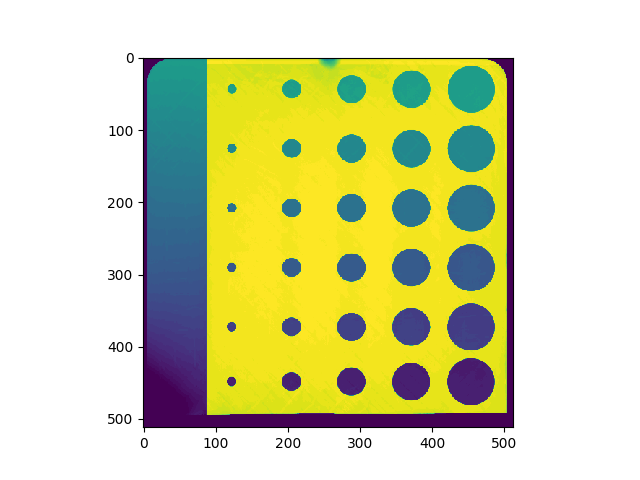

In [5]:
specimen_idx = 2
ground_truth = Y[specimen_idx, :, :]

plt.imshow(ground_truth)

In [6]:
import numpy as np
from Util import Helper
import pdb

def segment_circles(img, minDist=60, param1=255, param2=17, minRadius=0, maxRadius=80):
    if img.dtype != np.uint8:
        img = Helper.min_max_norm(img, 0, 255, dtype=np.uint8)
    # img = cv2.imread('opencv_logo.png', 0)
    img = cv2.medianBlur(img, 5)
    cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, minDist,
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    
    if circles is not None:
        print('Found %s boreholes.' % circles.shape[1])
        circles = np.uint16(np.around(circles))
    
        # sort first by x then by y
        circles = circles[:, np.lexsort((circles[0,:,0], circles[0,:,1])), :]
    
        for i in circles[0, :]:
          # draw the outer circle
          cv2.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2)
          # draw the center of the circle
          cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3)

    return cimg, circles

Found 30 boreholes.


<IPython.core.display.Javascript object>


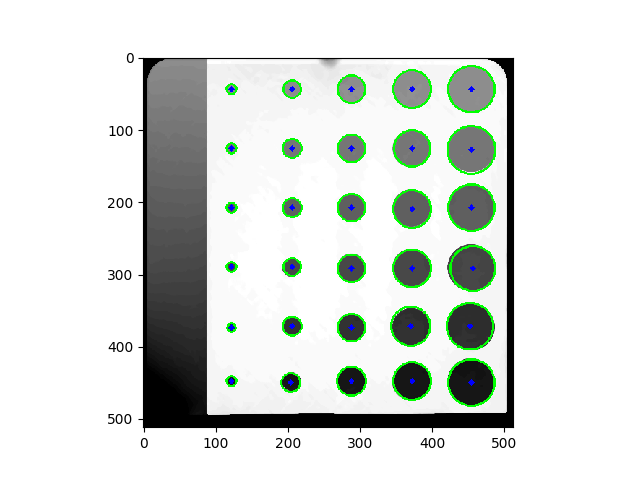

In [7]:
specimen_idx = 2
Y_test = Y[specimen_idx, :, :]
Y_test_with_circles, Y_test_circles = segment_circles(ground_truth)

plt.imshow(Y_test_with_circles)

In [8]:
import keras


model_path = './LOSS-mae_BS-256_OPT-nadam_Dense-64-selu-21_Dense-64-selu_Dense-64-tanh_Dense-1-relu/model.h5'
# model_path = './LOSS-mae_BS-256_OPT-nadam_Dense-64-selu-21_Dense-64-selu_Dense-64-selu_Dense-1-relu/best_model.h5'
model_path = './LOSS-mae_BS-256_OPT-nadam_Dense-64-selu-21_Dense-64-selu_Dense-64-tanh_Dense-1-relu/best_model.h5'
model = keras.models.load_model(model_path)
print(model.summary())

Using TensorFlow backend.
W1002 09:28:05.564674 139720076801664 deprecation.py:237] From /home/konerg/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4139: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________
None


<IPython.core.display.Javascript object>


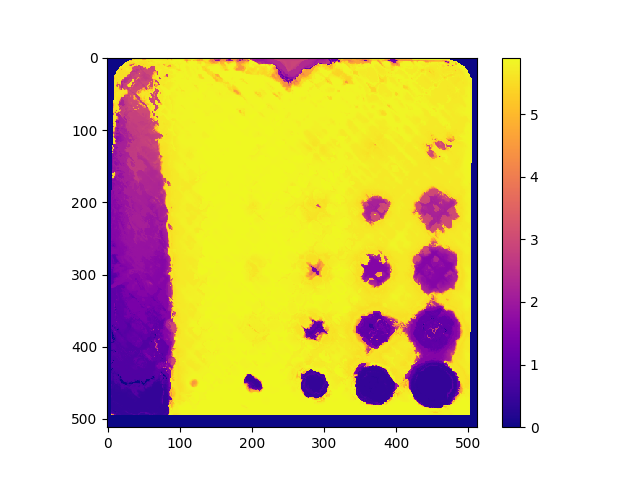

In [9]:
X_test = X[2, :, :, :]
X_test = X_test.astype(np.float64) / 255
X_test = X_test.reshape(-1, input_dim)

Y_hat = model.predict(X_test)
plt.imshow(Y_hat.reshape(512, 512), cmap='plasma')
plt.colorbar()

In [10]:
Y_hat = Y_hat.reshape(512, 512)

#Y_hat_with_circles, Y_hat_circles = segment_circles(Y_hat, minDist=60, param1=200, param2=17, minRadius=0, maxRadius=80)
Y_hat_with_circles, Y_hat_circles = segment_circles(Y_hat, minDist=60, param1=160, param2=10, minRadius=0, maxRadius=80) #13 25 35
#Y_hat_with_circles, Y_hat_circles = segment_circles(Y_hat, minDist=60, param1=160, param2=8, minRadius=0, maxRadius=80) # 14 25 35
#Y_hat_with_circles, Y_hat_circles = segment_circles(Y_hat, minDist=60, param1=255, param2=200, minRadius=0, maxRadius=80)
plt.imshow(Y_hat_with_circles)

Found 24 boreholes.


<IPython.core.display.Javascript object>

In [11]:
Y_hat_circles

array([[[260,  10,  28],
        [ 40,  28,  26],
        [460,  62,  61],
        [188,  66,  65],
        [296,  68,  66],
        [ 80,  76,  73],
        [ 24,  98,  15],
        [100, 152,  26],
        [440, 176,  64],
        [494, 238,  36],
        [390, 254,  65],
        [ 74, 280,  13],
        [454, 294,  32],
        [330, 304,  61],
        [398, 318,  50],
        [368, 376,  25],
        [286, 378,  13],
        [454, 378,  35],
        [ 52, 398,  48],
        [370, 448,  32],
        [120, 450,   4],
        [204, 452,   8],
        [284, 452,  20],
        [450, 458,  38]]], dtype=uint16)

In [12]:
# prepare points from small to big for 1mm thickness
c1_true = Y_test_circles[0, 23, :]
c2_true = Y_test_circles[0, 20, :]
c3_true = Y_test_circles[0, 24, :]
c4_true = Y_test_circles[0, 21, :]
c5_true = Y_test_circles[0, 22, :]

c1_hat = None
c2_hat = None
c3_hat = Y_hat_circles[0, 16, :]
c4_hat = Y_hat_circles[0, 15, :]
c5_hat = Y_hat_circles[0, 17, :]


C_true = [c3_true, c4_true, c5_true]
C_hat  = [c3_hat,  c4_hat, c5_hat]

test = np.copy(Y_hat.reshape(512, 512))
test = Helper.min_max_norm(test, 0, 255, np.uint8)
test = cv2.cvtColor(test, cv2.COLOR_GRAY2BGR)

for idx, c in enumerate(C_true):
    # draw the outer circle
    # ground truth
    cv2.circle(test, (c[0], c[1]), c[2], (0, 255, 0), 2)
    # predictions
    cv2.circle(test, (C_hat[idx][0], C_hat[idx][1]), C_hat[idx][2], (255, 0, 0), 2)
    # draw the center of the circle
    #cv2.circle(test, (c[0], c[1]), 2, (0, 0, 255), 3)

plt.imshow(test)

<IPython.core.display.Javascript object>

In [13]:
def mape_per_hole(radius_true, radius_hat):
    """
    Computes the mean absolute percentage error for two given holes
    """
    a_true = radius_true * np.pi ** 2
    a_hat = radius_hat * np.pi ** 2
    result = np.abs((a_true - a_hat) / a_true)
    return result

In [14]:
def find_largest_circle_from_center(y_hat, x, y):
    pass

In [15]:
sum = 0
for idx, c_true in enumerate(C_true):
    x = c_true[0]
    y = c_true[1]
    radius_true = c_true[2]
    radius_hat =  C_hat[idx][2]
    print(x, y, radius_true, radius_hat)
    mape = mape_per_hole(radius_true, radius_hat)
    print(mape)
    sum += mape
total_mape = sum / len(C_true)
print('Total mean absolute percentage error: %s' % total_mape)

288 374 19 13
0.3157894736842106
370 372 27 25
0.074074074074074
452 372 32 35
0.09375000000000003
Total mean absolute percentage error: 0.16120451591942822


In [16]:
def mape(y, y_hat):
    return np.abs((y - y_hat) / y) * 100

In [17]:
# Source: https://stackoverflow.com/questions/44865023/circular-masking-an-image-in-python-using-numpy-arrays
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

Found 30 boreholes.


<IPython.core.display.Javascript object>


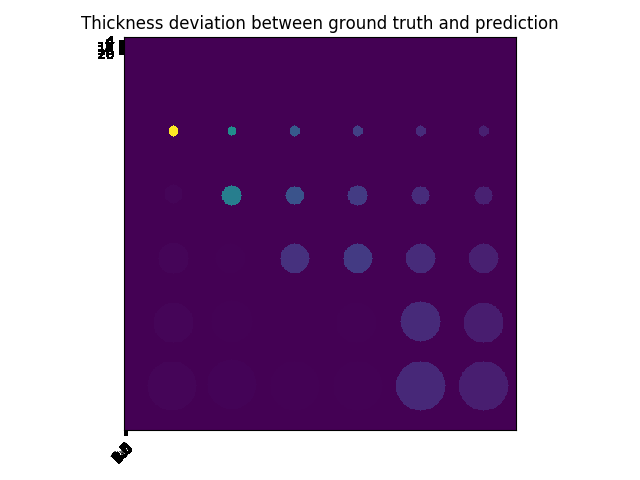

In [23]:
import imutils
import matplotlib

def borehole_depth(Y, Y_hat, radius=7):
    # rotate ground truth and prediction
    Y = imutils.rotate(Y, 270)
    Y_hat = imutils.rotate(Y_hat, 270)
    h, w = Y.shape
    # find boreholes in ground truth
    cimg, circles = segment_circles(Y)
    
    bore_holes = np.zeros((h, w))

    x_ticks = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    x_num = len(x_ticks)
    x_ticks = [tick for tick in x_ticks for j in range(w // x_num)]
    y_ticks = [20, 16, 12, 8, 4]
    y_num = len(y_ticks)
    y_ticks = [tick for tick in y_ticks for j in range(h // y_num)]
    
    for x, y, r in circles[0, :]:
        mask = create_circular_mask(h, w, (x, y), radius)
        y_borehole = mask * Y
        y_thickness = y_borehole[y_borehole != 0]
        y_thickness = np.median(y_thickness)
        
        y_hat_borehole = mask * Y_hat
        y_hat_thickenss = y_hat_borehole[y_hat_borehole != 0]
        y_hat_thickness = np.median(y_hat_thickenss)
        
        deviation = mape(y_thickness, y_hat_thickness)
    
        mask = create_circular_mask(h, w, (x, y), r)
        mask = mask.astype(np.float)
        mask[mask == 1.0] = deviation
        
        
        bore_holes = bore_holes + mask
    
    # bore_holes[bore_holes == bore_holes.max()] = 0
    # bore_holes[bore_holes == 0] = 255
    fig, ax = plt.subplots()
    im = ax.imshow(bore_holes)
    
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    ax.set_title('Thickness deviation between ground truth and prediction')
    
    fig.tight_layout()
    
    #plt.imshow(bore_holes)
    #cb = plt.colorbar()
    #cb.set_label('Devation in %')
    
borehole_depth(Y_test, Y_hat)

In [142]:
import seaborn as sns
import imutils


def borehole_depth_2(Y, Y_hat, radius=7):
    Y = cv2.resize(Y, (256, 256))
    Y_hat = cv2.resize(Y_hat, Y.shape)
    # rotate ground truth and prediction
    Y = imutils.rotate(Y, 270)
    Y_hat = imutils.rotate(Y_hat, 270)    
    h, w = Y.shape
    # find boreholes in ground truth
    cimg, circles = segment_circles(Y, minDist=30, maxRadius=20, param1=255, param2=9) #minDist=60, param1=255, param2=17, minRadius=0, maxRadius=80
    # cv2.imshow('ground', cimg)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    bore_holes = np.zeros((h, w))

    x_ticks = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
    x_num = len(x_ticks)
    #x_ticks = [tick for tick in x_ticks for j in range(w // x_num)]
    y_ticks = [20, 16, 12, 8, 4]
    y_num = len(y_ticks)
    #y_ticks = [tick for tick in y_ticks for j in range(h // y_num)]
    
    annotations = np.zeros(bore_holes.shape, dtype=float)
    
    for x, y, r in circles[0, :]:
        if y > 20:
            mask = create_circular_mask(h, w, (x, y), radius)
            y_borehole = mask * Y
            y_thickness = y_borehole[y_borehole != 0]
            y_thickness = np.median(y_thickness)

            y_hat_borehole = mask * Y_hat
            y_hat_thickenss = y_hat_borehole[y_hat_borehole != 0]
            y_hat_thickness = np.median(y_hat_thickenss)

            deviation = mape(y_thickness, y_hat_thickness)
            mask = create_circular_mask(h, w, (x, y), r)
            mask = mask.astype(np.float)
            mask[mask == 1.0] = deviation

            annotations[y, x] = deviation

            bore_holes = bore_holes + mask
    
    cbar_kws = {
        #'ticks': [0.0, 50.0, 100.0, 150.0, 1000.],
        'label': 'Thickness deviation in %'
    }
    cmap = 'Paired'
    mask = np.zeros(bore_holes.shape, dtype=bool)
    mask = bore_holes <= 0.
    ax = sns.heatmap(bore_holes, cmap=cmap, mask=mask,
                     cbar_kws=cbar_kws)
    ax.set_xlabel('Thickness / mm')
    ax.set_ylabel('Diameter / mm')
    
    #plt.xticks(x_ticks)
    #plt.yticks(y_ticks)
    #plt.gca().set_xticks(x_ticks)
    print(x_ticks)
    plt.xticks(x_ticks)
    # draw annotations
    for y, x in np.ndindex(annotations.shape):
        anno = annotations[y, x]
        if anno > 0.:
            plt.annotate('%.1f' % anno, (x - 10, y - 10))
    
borehole_depth_2(Y_test, Y_hat)

Found 31 boreholes.


<IPython.core.display.Javascript object>

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]


In [24]:
Y_test_circles

array([[[122,  44,   7],
        [206,  44,  12],
        [288,  44,  19],
        [372,  44,  26],
        [454,  44,  32],
        [122, 126,   7],
        [206, 126,  13],
        [288, 126,  19],
        [372, 126,  25],
        [454, 128,  33],
        [122, 208,   7],
        [206, 208,  13],
        [288, 208,  19],
        [454, 208,  32],
        [372, 210,  26],
        [122, 290,   7],
        [206, 290,  12],
        [288, 292,  19],
        [372, 292,  26],
        [456, 292,  31],
        [206, 372,  13],
        [370, 372,  27],
        [452, 372,  32],
        [122, 374,   6],
        [288, 374,  19],
        [122, 448,   7],
        [288, 448,  20],
        [372, 448,  26],
        [204, 450,  13],
        [454, 450,  32]]], dtype=uint16)

In [133]:
annotations = np.zeros((5, 6), dtype=int)
for y, x in np.ndindex(annotations.shape):
    print(y,x)

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5


TypeError: 'tuple' object is not callable